In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/a45329/miniconda/envs/zj63/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Generate data

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.1
x_dim, z_m_dim, hidden_dim = 50, 2, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c2 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + noise).reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 3.1523
True ACME (treatment) = 3.1523
True ADE (control) = -1.0012
True ADE (treatment) = -1.0012
True ATE = 2.1511


# 2. Fit IMAVAE with a regular VAE backbone

In [4]:
# Use same hyperparameters
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, optim_name='Adam', 
                recon_weight=0.1, elbo_weight=0.1, sup_weight=1., identifiable=False)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 113, Best Recon MSE: 0.0100233, Best Pred Metric [0.0211


Saving the last epoch with training MSE: 0.0098923 and Pred Metric: [0.022122152, 0.022122152]
Loaded the best model from Epoch: 113 with MSE: 0.0100233 and Pred Metric: [0.02113211, 0.02113211]
ACME (control) = 0.0013 +/- 0.0221
ACME (treatment) = -0.0010 +/- 0.0240
ADE (control) = -0.6557 +/- 0.0000
ADE (treatment) = -0.6557 +/- 0.0000
ATE = -0.6579 +/- 0.0238
-------------------------------------
ACME err (control) = 3.1509 +/- 0.0221
ACME err (treatment) = 3.1533 +/- 0.0240
ADE err (control) = 0.3455 +/- 0.0000
ADE err (treatment) = 0.3455 +/- 0.0000
ATE err = 2.8089 +/- 0.0238


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_23734/4220631630.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


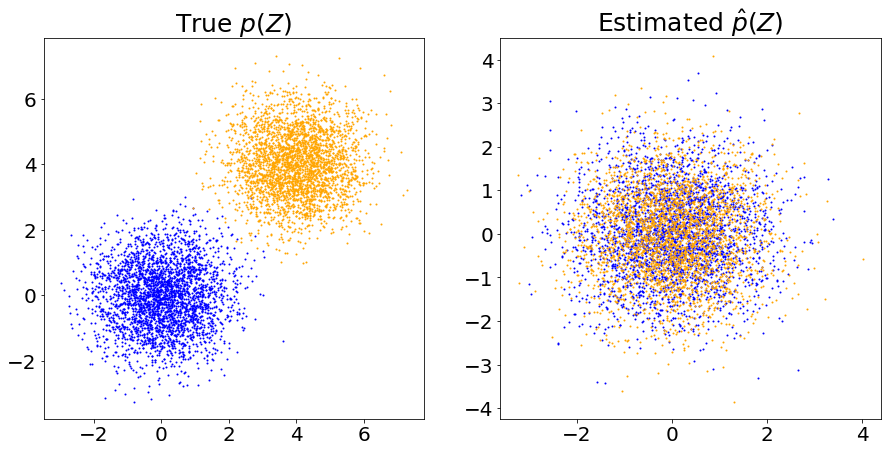

In [5]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z)$", size=25)
plt.savefig('./Figures/case_a_lr_regular_vae.png', dpi=1200)

#### 2.1.1 How does the reconstructed $X$ look like?

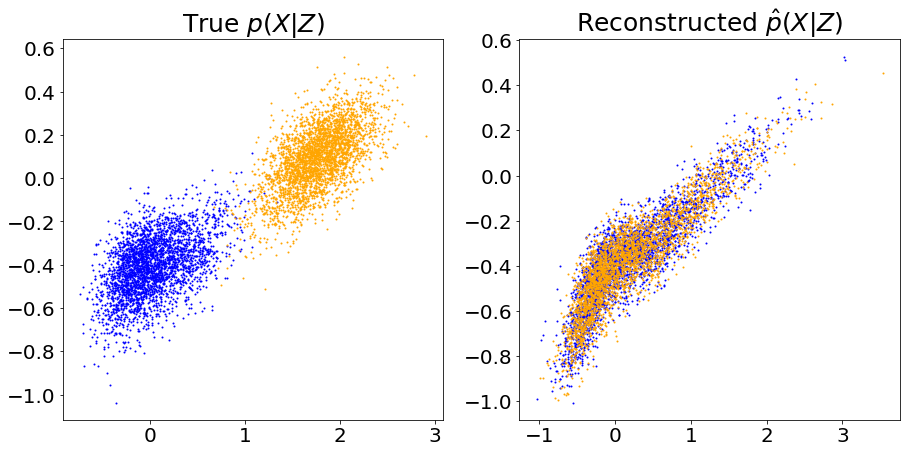

In [6]:
# Only plot the first 2 dimensions of X for better visualization
with torch.no_grad():
    x_m = imavae.ivae.decoder_dist.sample(*imavae.ivae.decoder_params(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(X[i,0], X[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(x_m[i,0], x_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(X|Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Reconstructed $\hat{p}(X|Z)$", size=25)
plt.savefig('./Figures/case_a_recon_regular_vae.png', dpi=1200)

# 3. Generate Data with observed covariates

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{w} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{\theta}, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [7]:
N = 6000
c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
x_dim, z_m_dim, w_dim, hidden_dim = 50, 2, 10, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)
g = nn.Sequential(
    nn.Linear(w_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, z_m_dim)
)

theta = np.random.uniform(-1,1,size=w_dim)
W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
logit = W @ theta
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
with torch.no_grad():
    gw = g(torch.tensor(W).float()).numpy()
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c3 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
gamma1 = np.random.uniform(-1,1,size=w_dim)
gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)

In [8]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + W @ gamma1 + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + W @ gamma1 + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = -6.3217
True ACME (treatment) = -6.3217
True ADE (control) = -0.5107
True ADE (treatment) = -0.5107
True ATE = -6.8323


# 4. Fit IMAVAE with a regular VAE backbone on the new dataset

In [9]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, optim_name='Adam', 
                recon_weight=1., elbo_weight=1., sup_weight=1., identifiable=False)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 106, Best Recon MSE: 0.0101262, Best Pred Metric [0.6104


Saving the last epoch with training MSE: 0.00997463 and Pred Metric: [0.6326368, 0.6326368]
Loaded the best model from Epoch: 106 with MSE: 0.0101262 and Pred Metric: [0.6104183, 0.6104183]
ACME (control) = -0.0068 +/- 0.0376
ACME (treatment) = -0.0011 +/- 0.0415
ADE (control) = -1.7538 +/- 0.0000
ADE (treatment) = -1.7538 +/- 0.0000
ATE = -1.7594 +/- 0.0326
-------------------------------------
ACME err (control) = 6.3148 +/- 0.0376
ACME err (treatment) = 6.3206 +/- 0.0415
ADE err (control) = 1.2431 +/- 0.0000
ADE err (treatment) = 1.2431 +/- 0.0000
ATE err = 5.0730 +/- 0.0326


### 4.1 Does the latent feature learned by IMAVAE recover the true mediator?

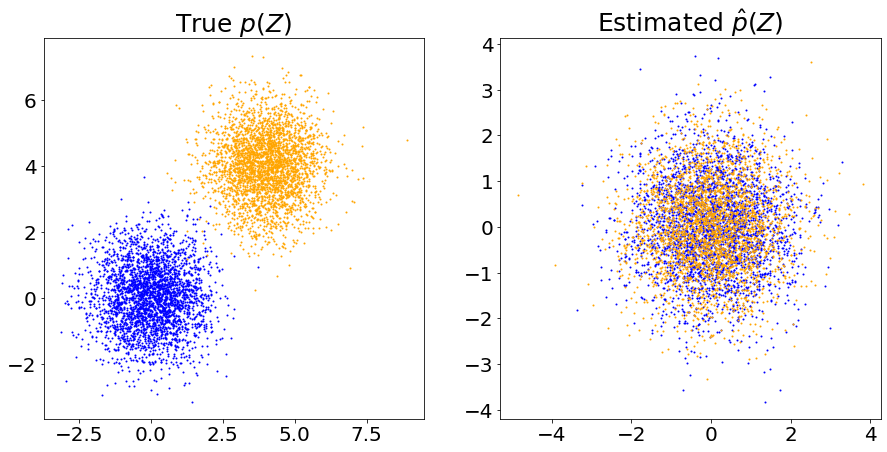

In [10]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z)$", size=25)
plt.savefig('./Figures/case_b_lr_regular_vae.png', dpi=1200)

#### 4.1.1 How does the reconstructed $X$ look like?

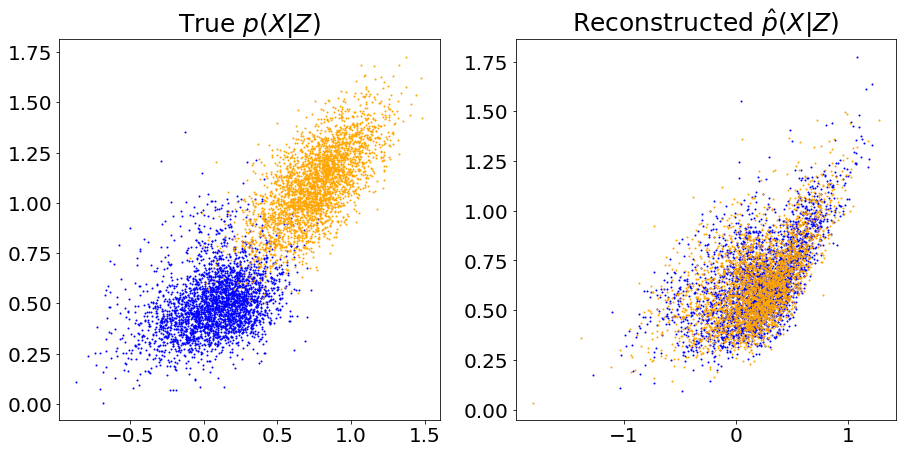

In [11]:
# Only plot the first 2 dimensions of X for better visualization
with torch.no_grad():
    x_m = imavae.ivae.decoder_dist.sample(*imavae.ivae.decoder_params(z_m))

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(X[i,0], X[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(x_m[i,0], x_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(X|Z)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Reconstructed $\hat{p}(X|Z)$", size=25)
plt.savefig('./Figures/case_b_recon_regular_vae.png', dpi=1200)